In [1]:
!nvidia-smi

Tue Jan 15 21:47:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 28%   70C    P2    92W / 250W |   1325MiB / 12204MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%matplotlib inline

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [4]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import decomposition, manifold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
colors = np.array([
    [166,206,227],
    [31,120,180],
    [178,223,138],
    [51,160,44],
    [251,154,153],
    [227,26,28],
    [253,191,111],
    [255,127,0],
    [202,178,214],
    [106,61,154],
]) / 255.0

colors_init = np.hstack((colors, np.zeros((colors.shape[0], 1))))
colors_full = np.hstack((colors, np.ones((colors.shape[0], 1))))

cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("S0", [colors_init[i], colors_full[i]])
         for i in range(colors.shape[0])]

In [6]:
#MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
MNIST_MEAN, MNIST_STD = 0, 1
mnist_train_dataset = datasets.MNIST('../data', train=True, download=True)
mnist_test_dataset = datasets.MNIST('../data', train=False, download=True)
mnist_train_tensors = (
    (mnist_train_dataset.train_data[:50000].float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_train_dataset.train_labels[:50000])
mnist_valid_tensors = (
    (mnist_train_dataset.train_data[50000:].float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_train_dataset.train_labels[50000:])
mnist_test_tensors = (
    (mnist_test_dataset.test_data.float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_test_dataset.test_labels)

In [7]:
def dist_sq(X, Y=None, diag_mask=None):
    X2 = (X ** 2).sum(1)[:, None]
    if Y is None:
        Y = X
        Y2 = X2.t()
    else:
        Y2 = (Y ** 2).sum(1)[None, :]
    D = X2 + Y2
    D -= 2 * torch.matmul(X, Y.t())
    # mask stuff on the diagonal
    if (Y is not None) and (diag_mask is not None):
        D.view(-1)[::D.size(0)+1] = diag_mask
    return D

In [8]:
#C1S, C2S, F1S = 20, 50, 500
C1S, C2S, F1S = 20, 50, 200

def assert_nonnan(F):
    if torch.any(torch.isnan(F)).item():
        print ("Nan detected, bailing out")
        raise ValueError("Oh noes, NaN")

class KNNNet(nn.Module):
    def __init__(self):
        super(KNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, C1S, 5, 1)
        self.conv2 = nn.Conv2d(C1S, C2S, 5, 1)
        self.fc1 = nn.Linear(4*4*C2S, F1S)
        # self.fc2 = nn.Linear(500, 10)
        
        self.normalize = True
        self.eps = 1e-4
        self.delta = 0.2 #  dla 0.1 mamy 0.994 acc
        self.k = 5

    def forward(self, x):
        x = x[:, None, :, :]  # add the channel dim
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        x = x.view(x.size(0), -1)
        if self.normalize:
            x_len = (x**2).sum(1)[:, None]
            x = x / torch.sqrt(x_len + self.eps)
        return x
    
    def loss(self, X, Y):
        k = self.k
        kp = int(np.ceil(k / 2))
        kn = int(np.floor(k / 2))
        
        F = self(X)
        assert_nonnan(F)
        with torch.no_grad():
            D = dist_sq(F, diag_mask=1e20)
            _, idx = torch.topk(-D, k)
            mistakes = torch.nonzero(torch.mode(Y[idx])[0] != Y).view(-1)
            acc = 1.0 - 1.0 * mistakes.size(0) / Y.size(0) 
        Fm = F  # [mistakes]
        Ym = Y  # [mistakes]
        Dm = D  # [mistakes]
        correct_mask_m = (Ym[:, None] == Y[None, :]).float()
        _, kp_correct_m = torch.topk(
            -Dm - (1 - correct_mask_m)*1e20, kp)
        _, kn_incorrect_m = torch.topk(
            -Dm - correct_mask_m * 1e20, kn)

        dists_p = torch.sqrt(((Fm[:, None, :] - F[kp_correct_m] + self.eps)**2).sum(-1))
        dists_n = torch.sqrt(((Fm[:, None, :] - F[kn_incorrect_m] + self.eps)**2).sum(-1))

        loss = torch.max(dists_p[:, :, None] - dists_n[:, None, :] + self.delta,
                         torch.tensor(0.0, device=dists_p.device)
                        ).view(1, -1).mean()
        return loss, acc
    
    def knn_predict(self, train_x, train_y, test_x, train_chunk_size=30000):
        with torch.no_grad():
            Ftest = model(test_x)
            assert_nonnan(Ftest)
            D = torch.empty(test_x.size(0), train_x.size(0)).fill_(np.nan)
            
            for i in range(0, train_x.size(0), train_chunk_size):
                Ftrain = model(train_x[i:i + train_chunk_size])
                assert_nonnan(Ftrain)
                D[:, i:i + train_chunk_size] = dist_sq(Ftest, Ftrain)
            assert_nonnan(D)
            top_dists, nearest = torch.topk(-D, self.k)
            nearest_classes = train_y[nearest]
            preds, _ = torch.mode(nearest_classes)
        return preds

In [9]:
import torch.utils.data

class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None, batch_sampler=None,
                 drop_last=False):
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [10]:
class args:
    seed = 1
    batch_size = 256
    test_batch_size = 1000
    epochs = 20

    lr = 0.01
    momentum = 0.5

    log_interval = 100
    use_cuda = True
    
    save_model = True

In [11]:
torch.manual_seed(args.seed)

device = torch.device("cuda" if args.use_cuda else "cpu")

train_loader = InMemDataLoader(
    mnist_train_tensors, batch_size=args.batch_size, shuffle=True).to(device)
test_loader = InMemDataLoader(
    mnist_test_tensors, batch_size=args.test_batch_size, shuffle=False).to(device)

model = KNNNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# train_x, train_y = mnist_train_tensors
# test_x, test_y = mnist_test_tensors
train_x, train_y = train_loader.dataset.tensors
test_x, test_y = test_loader.dataset.tensors

model.train()
for epoch in range(args.epochs):
    model.eval()
    # model.to("cpu")
    preds = model.knn_predict(train_x, train_y, test_x)
    acc = (preds == test_y).float().mean()
    # model.to(device)
    model.train()
    print("Start Epoch %d, test acc: %.6f" % (epoch, acc))
    for batch_idx, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        loss, acc = model.loss(X, Y) # MOD XXX
        loss.backward()
        g_norm = 0.0
        for p in model.parameters():
            # assert_nonnan(p)
            # assert_nonnan(p.grad)
            g_norm += torch.sum(p.grad**2)
        g_norm = torch.sqrt(g_norm)
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tGNorm: {:.6g}\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), g_norm.item(), loss.item(), acc))

Start Epoch 0, test acc: 0.968700
Train Epoch: 0 [0/50000 (0%)]	GNorm: 0.411009	Loss: 0.165833	Acc: 0.789062
Train Epoch: 0 [25600/50000 (51%)]	GNorm: 0.0617103	Loss: 0.016253	Acc: 0.976562
Start Epoch 1, test acc: 0.991700
Train Epoch: 1 [0/50000 (0%)]	GNorm: 0.0421723	Loss: 0.008718	Acc: 0.992188
Train Epoch: 1 [25600/50000 (51%)]	GNorm: 0.0295049	Loss: 0.006627	Acc: 0.988281
Start Epoch 2, test acc: 0.992400
Train Epoch: 2 [0/50000 (0%)]	GNorm: 0.0187001	Loss: 0.001757	Acc: 1.000000
Train Epoch: 2 [25600/50000 (51%)]	GNorm: 0.0211626	Loss: 0.002695	Acc: 0.996094
Start Epoch 3, test acc: 0.992600
Train Epoch: 3 [0/50000 (0%)]	GNorm: 0.0223318	Loss: 0.003853	Acc: 0.988281
Train Epoch: 3 [25600/50000 (51%)]	GNorm: 0.0249616	Loss: 0.006960	Acc: 0.988281
Start Epoch 4, test acc: 0.992800
Train Epoch: 4 [0/50000 (0%)]	GNorm: 0.0247878	Loss: 0.004280	Acc: 0.992188
Train Epoch: 4 [25600/50000 (51%)]	GNorm: 0.0277849	Loss: 0.006789	Acc: 0.988281
Start Epoch 5, test acc: 0.994200
Train Epoch:

predicted: 7
0 K: 26.793413, S: 0.000000, D: 5.420122, tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0'), tensor([0.0047, 0.0100, 0.0114, 0.0121, 0.0131, 0.0136, 0.0138, 0.0145, 0.0151,
        0.0154, 0.0154], device='cuda:0', grad_fn=<TakeBackward>)
100 K: 0.572339, S: 0.000000, D: 5.554603, tensor([7, 7, 7, 1, 1, 1, 7, 1, 1, 7, 2], device='cuda:0'), tensor([0.8659, 0.9071, 0.9125, 0.9172, 0.9211, 0.9245, 0.9255, 0.9273, 0.9274,
        0.9311, 0.9351], device='cuda:0', grad_fn=<TakeBackward>)
200 K: 0.484150, S: 0.000000, D: 5.617676, tensor([7, 7, 1, 1, 7, 1, 1, 7, 2, 1, 2], device='cuda:0'), tensor([0.8887, 0.9123, 0.9277, 0.9279, 0.9314, 0.9341, 0.9374, 0.9402, 0.9410,
        0.9421, 0.9442], device='cuda:0', grad_fn=<TakeBackward>)
300 K: 0.503877, S: 0.000000, D: 5.591983, tensor([7, 7, 1, 1, 7, 1, 7, 1, 1, 7, 2], device='cuda:0'), tensor([0.8784, 0.9119, 0.9240, 0.9254, 0.9277, 0.9283, 0.9296, 0.9334, 0.9365,
        0.9401, 0.9418], device='cuda:0', grad_fn=<TakeBac

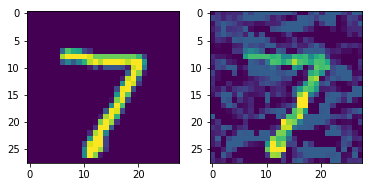

In [12]:
num = 0
k = 11
desired = 1
new_x = test_x[num]
adv_x = torch.clone(new_x)
adv_x.requires_grad_(True)
new_y = test_y[num]

train_xs = train_x[:20000]
train_ys = train_y[:20000]

print("predicted:", model.knn_predict(train_xs, train_ys, new_x[None, :, :]).item())

opt = torch.optim.Adam([adv_x], lr=1e-2)

with torch.no_grad():
    feats_xs = model(train_xs)

i = 0
while True:
    opt.zero_grad()
    feats_adv_x = model(adv_x[None, :, :])
    dists = torch.sum((feats_xs - feats_adv_x)**2, dim=(1,))
    pdists, _ = torch.topk(dists[train_ys == desired], k=(k+1)//2, largest=False)
    ndists, _ = torch.topk(dists[train_ys != desired], k=k//2, largest=False)
    knn_loss = (torch.max(pdists[None, :] - ndists[:, None], torch.tensor(0.0, device=new_x.device))).sum()
    dloss = torch.max(pdists, torch.tensor(0.05, device=pdists.device)).sum()
    sim_loss = torch.tensor(0.0, device=adv_x.device)
    with torch.no_grad():
        _, top_class = torch.topk(dists, k=k, largest=False)
        good = torch.mode(train_ys[top_class])[0].item() == desired
    loss = knn_loss + 0.00 * sim_loss + 1.0 * dloss
    
    if good and torch.all(pdists < 0.05).item():
        print('Done:', 'K: %f, S: %f, D: %f, %s, %s' %
              (knn_loss.item(), sim_loss.item(), dloss.item(), train_y[top_class], dists[top_class]))
        break
    
    if i%100 == 0:
        print(i, 'K: %f, S: %f, D: %f, %s, %s' %
              (knn_loss.item(), sim_loss.item(), dloss.item(), train_y[top_class], dists[top_class]))
    loss.backward()
    opt.step()
    with torch.no_grad():
        adv_x.data = torch.min(adv_x, new_x + 0.3)
        adv_x.data = torch.max(adv_x, new_x - 0.3)
        adv_x.data = adv_x.clamp(0, 1)
    i+=1
    

plt.subplot(121)
plt.imshow(new_x)
plt.subplot(122)
plt.imshow(adv_x.detach().cpu().numpy())


1

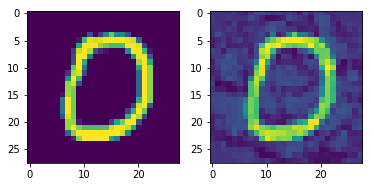

In [14]:
plt.subplot(121)
plt.imshow(new_x)
plt.subplot(122)
plt.imshow(adv_x.detach().cpu().numpy())

In [13]:
with torch.no_grad():
    F_train = model(train_x[:10000]).cpu().numpy()

In [14]:
pca = decomposition.PCA(2)
F_train_2d_pca = pca.fit_transform(F_train)

(-0.3697627055644989, 0.4351921546459198)

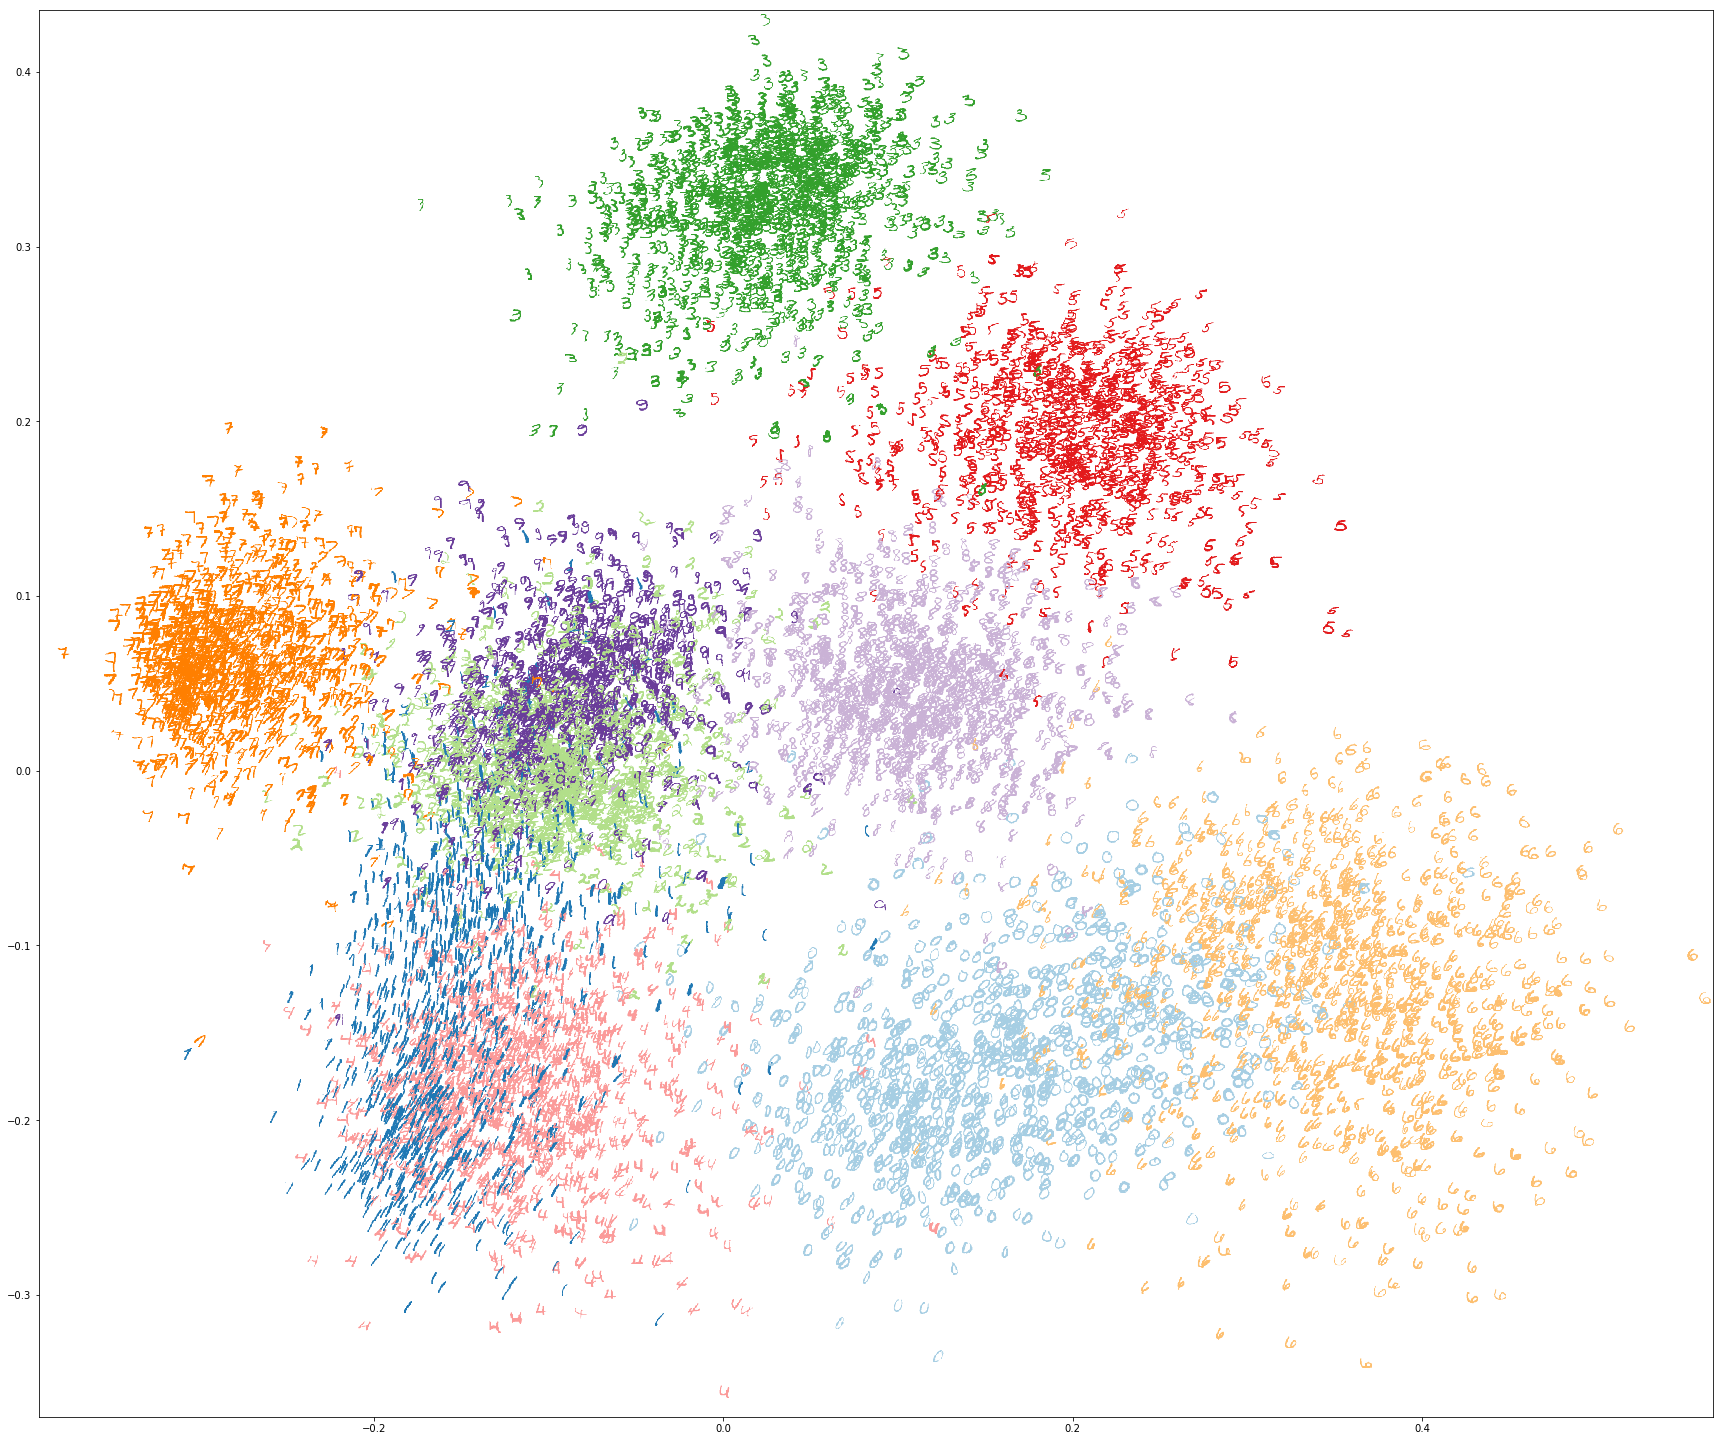

In [13]:
plt.figure(figsize=(30, 30))
ax = plt.gca()
mm =  (F_train_2d_pca[:,0].max() - F_train_2d_pca[:,0].min()) / 100.0
for i in range(10000):
    ax.imshow(train_x[i], cmap=cmaps[train_y[i]],
              extent=[F_train_2d_pca[i, 0], F_train_2d_pca[i, 0]+mm, F_train_2d_pca[i, 1], F_train_2d_pca[i, 1]+mm])
plt.xlim(F_train_2d_pca[:,0].min() - mm, F_train_2d_pca[:,0].max() + mm)
plt.ylim(F_train_2d_pca[:,1].min() - mm, F_train_2d_pca[:,1].max() + mm)

In [14]:
tsne = manifold.TSNE()
F_train_2d = tsne.fit_transform(F_train)

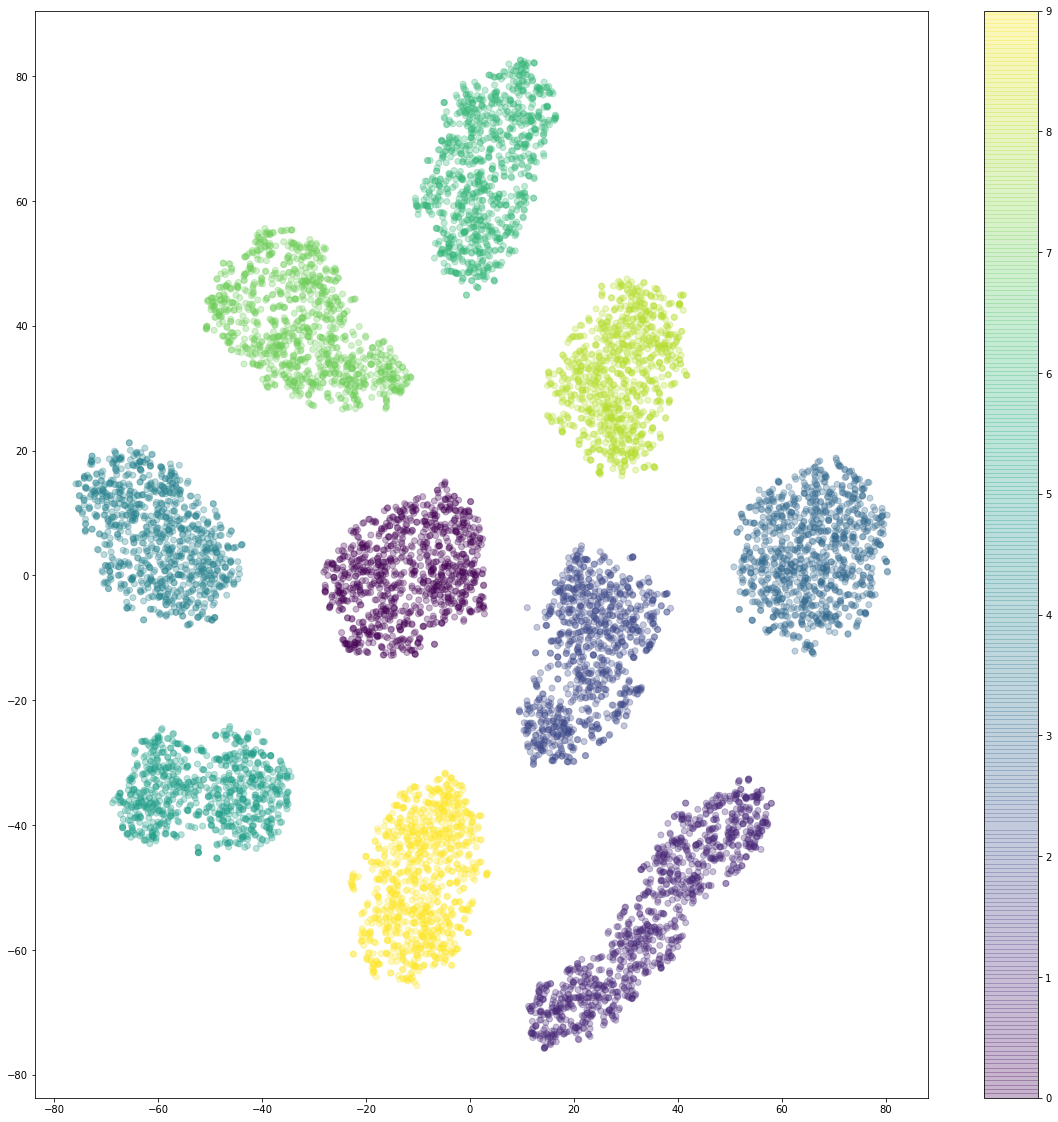

In [15]:
plt.figure(figsize=(20, 20))
plt.scatter(F_train_2d[:,0], F_train_2d[:,1], c=train_y[:F_train.shape[0]], alpha=0.3)
plt.colorbar()

(-77.33723846435547, 84.15745178222656)

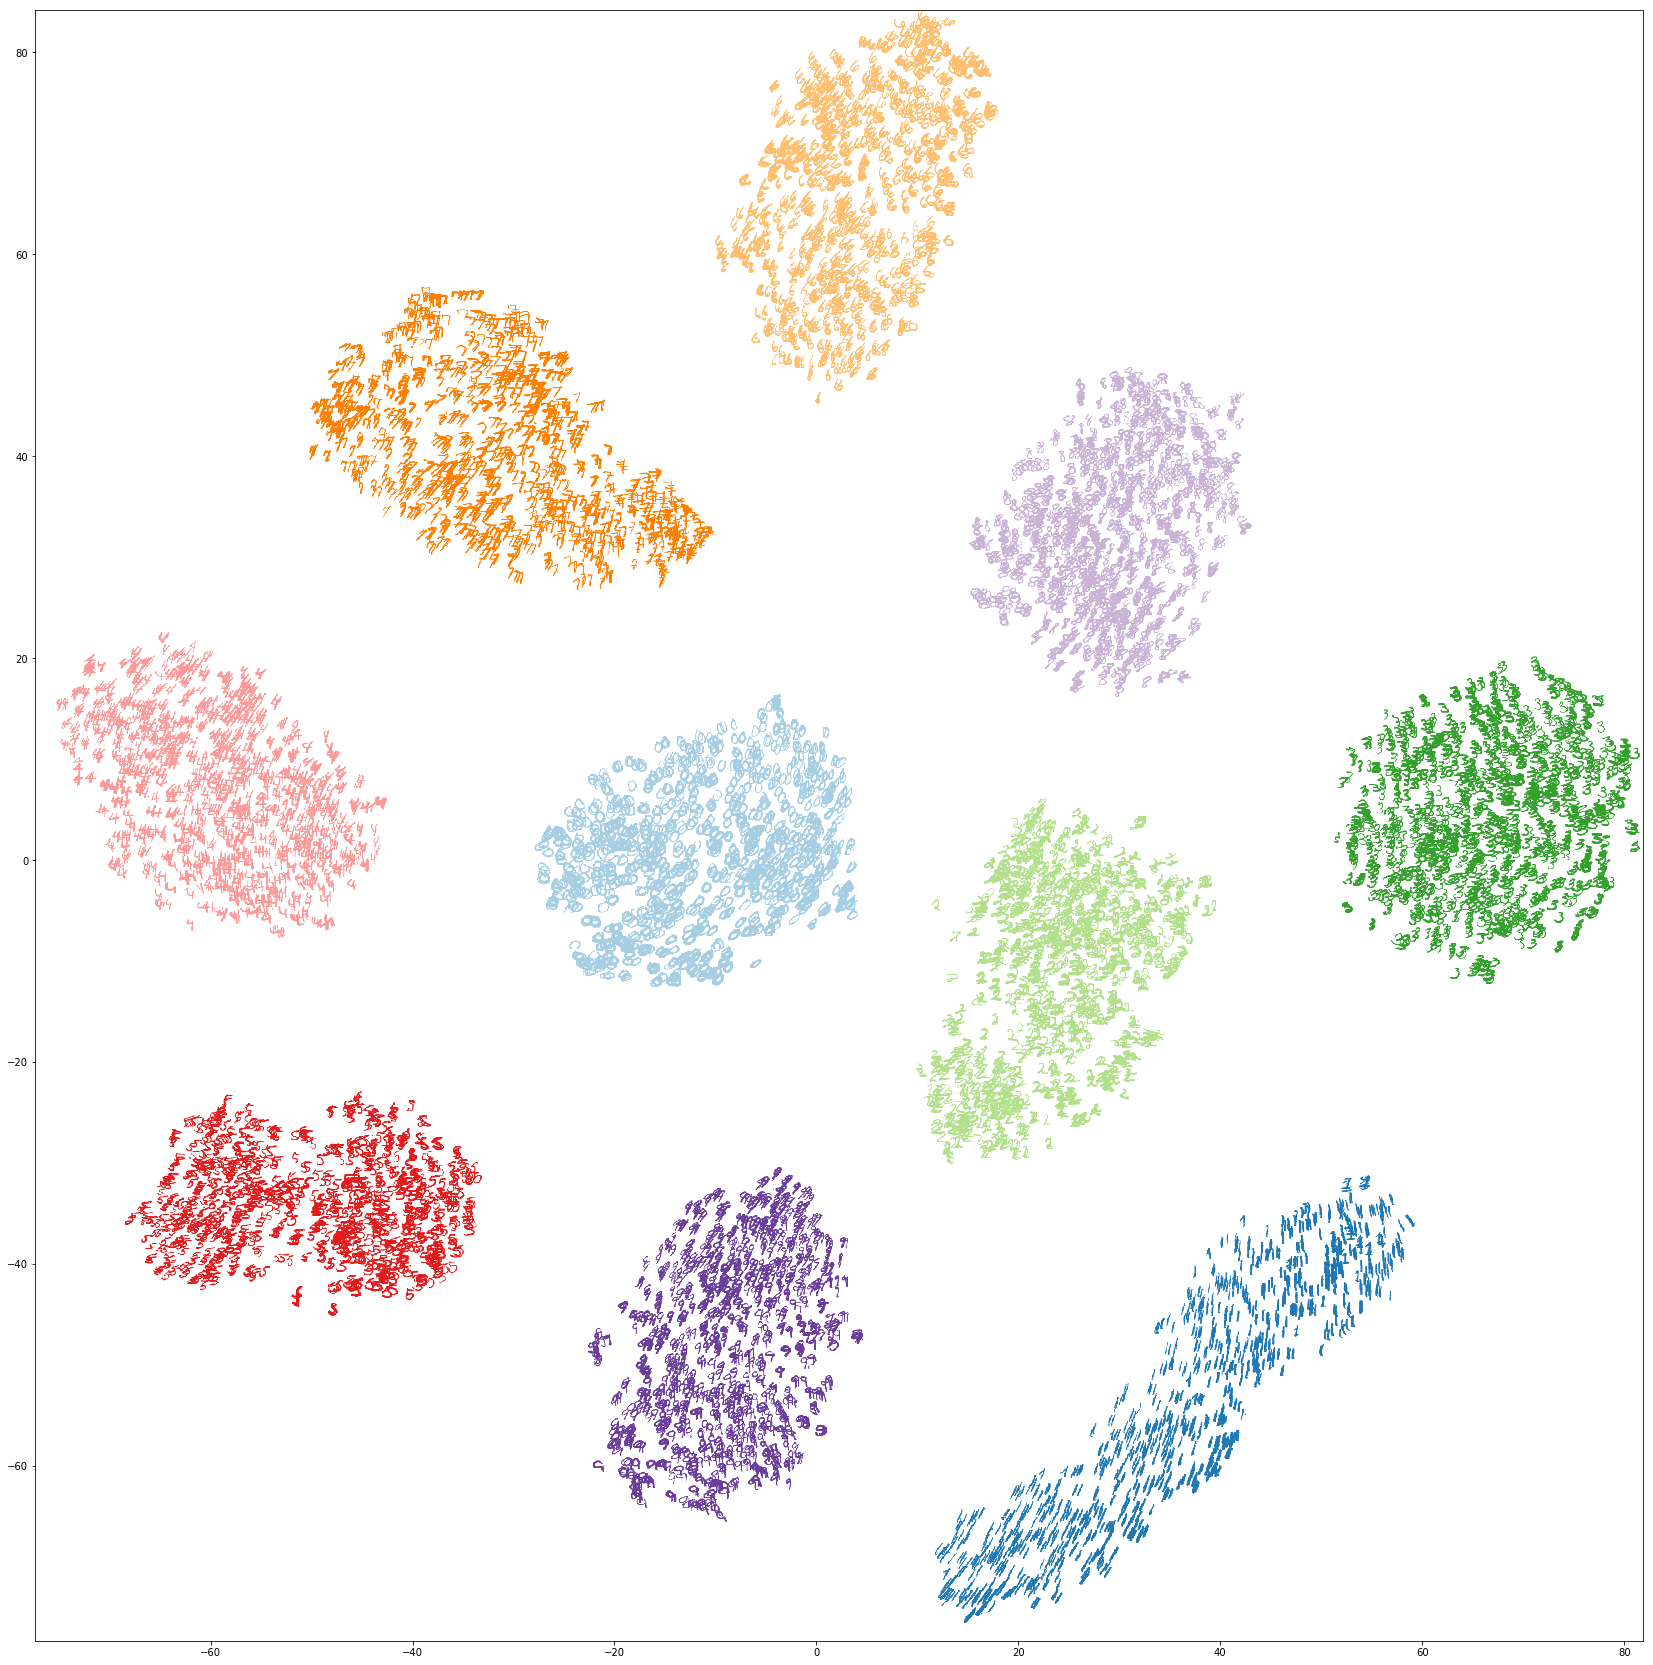

In [16]:
plt.figure(figsize=(30, 30))
ax = plt.gca()

mm =  (F_train_2d[:,0].max() - F_train_2d[:,0].min()) / 100.0
for i in range(10000):
    ax.imshow(train_x[i], cmap=cmaps[train_y[i]],
              extent=[F_train_2d[i, 0], F_train_2d[i, 0]+mm, F_train_2d[i, 1], F_train_2d[i, 1]+mm])
plt.xlim(F_train_2d[:,0].min() - mm, F_train_2d[:,0].max() + mm)
plt.ylim(F_train_2d[:,1].min() - mm, F_train_2d[:,1].max() + mm)